In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv("merged_data.csv")
print(data.head())

# Question 1

In [ ]:
beta = 2.0 * (len(data) / 100)  # Adjust beta from 100 trades per day to per second
lambda_ow = 0.0035  # Best Linear IC for OW suggested in paper
lambda_afs = 0.0035  # Best AFS IC 
p = 0.5 

signed_volume = data['Signed Volume'].values  # dQ_t
mid_price = data['mid_price'].values 
time_step = 1/len(data) 
J_t_ow = np.zeros(len(signed_volume))
J_t_afs = np.zeros(len(signed_volume))

# Simulate Jt for both models
for t in range(1, len(signed_volume)):
    # Update for OW model
    J_t_ow[t] = np.exp(-beta * time_step) * J_t_ow[t-1] + signed_volume[t]

    # AFS
    J_t_afs[t] = np.exp(-beta * time_step) * J_t_afs[t-1] + signed_volume[t]

I_ow = lambda_ow * J_t_ow  
I_afs = lambda_afs * np.sign(J_t_afs) * np.abs(J_t_afs)**p  
P_ow = mid_price + I_ow  
P_afs = mid_price + I_afs  

# Add results
data['Impact_OW'] = I_ow
data['Price_OW'] = P_ow
data['Impact_AFS'] = I_afs
data['Price_AFS'] = P_afs


plt.figure(figsize=(12, 6))

# OW Model Impact
plt.subplot(1, 2, 1)
plt.hist(I_ow, bins=50, alpha=0.7, label="OW Impact")
plt.title("Price Impact Distribution (OW Model)")
plt.xlabel("Price Impact")
plt.ylabel("Frequency")
plt.legend()

# AFS Model Impact
plt.subplot(1, 2, 2)
plt.hist(I_afs, bins=50, alpha=0.7, label="AFS Impact", color='orange')
plt.title("Price Impact Distribution (AFS Model)")
plt.xlabel("Price Impact")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()

# Visualize impacted prices
plt.figure(figsize=(12, 6))
plt.plot(data['ts_event'], P_ow, label="OW Model Impacted Price", alpha=0.7)
plt.plot(data['ts_event'], P_afs, label="AFS Model Impacted Price", alpha=0.7, linestyle='--')
plt.plot(data['ts_event'], mid_price, label="Original Mid Price", alpha=0.5, linestyle=':')
plt.xlabel("")  # Remove x-axis label for illustration better
plt.xticks([])  # Hide x-axis ticks
plt.ylabel("Price")
plt.title("Impacted Prices for OW and AFS Models")
plt.legend()
plt.show()



# Question 2

# Summary of Equations for the Optimal Strategy with Linear Impact

## Objective
The goal is to determine the optimal trading strategy \( Q_n \) that maximizes the expected profit and loss (PnL) while minimizing risk and trading costs. The optimization is based on the discrete formulation of the strategy.

---

## 1. Discrete Signal Dynamics
The mean-reverting signal \( f_n \) evolves as:
$$
f_n = f_{n-1} e^{-\phi \Delta t} + \sqrt{1 - e^{-2\phi \Delta t}} Z_n, \quad Z_n \sim \mathcal{N}(0, 1)
$$
- \( \phi \): Mean-reversion speed.
- \( \Delta t \): Time step.
- \( Z_n \): Random noise.

---

## 2. Trade Impact and Exponential Decay Kernel
The effect of past trades \( J_n \) is modeled with an exponential decay:
$$
J_n = e^{-\beta \Delta t} (J_{n-1} + Q_n - Q_{n-1})
$$
or equivalently:
$$
J_n + Q_n = e^{-\beta \Delta t} J_{n-1} + (1 - e^{-\beta \Delta t}) Q_n
$$
- \( \beta \): Decay rate of past trades.

---

## 3. Profit and Loss (PnL)
The discrete PnL consists of three components:
$$
\text{PnL}_n = \alpha_{\text{hat}} Q_n f_{n-1} - \lambda_{\text{hat}} |J_n + Q_n|^{p+1} - \frac{\gamma \sigma^2}{2} Q_n^2 \Delta t
$$
where:
$$
\alpha_{\text{hat}} = \frac{\alpha (1 - e^{-\beta \Delta t})}{\beta \Delta t}
$$
and
$$
\lambda_{\text{hat}} = \lambda \frac{1 - e^{-\beta (p+1)p \Delta t}}{\beta (p+1) \Delta t}
$$

---

## 4. Risk
The cumulative risk is:
$$
R_M(Q_n) = \sqrt{\frac{\gamma \sigma^2}{2} \sum_{n=1}^M Q_n^2 \Delta t}
$$

---

## 5. Sharpe Ratio
The Sharpe Ratio evaluates the performance of the strategy:
$$
\text{SR}(Q_n) = \frac{\text{PnL}_M(Q_n)}{R_M(Q_n)}
$$
where:
$$
\text{PnL}_M(Q_n) = \sum_{n=1}^M \left( \alpha_{\text{hat}} Q_n f_{n-1} - \lambda_{\text{hat}} |J_n + Q_n|^{p+1} - \frac{\gamma \sigma^2}{2} Q_n^2 \Delta t \right)
$$

---

## 6. Optimal Holdings
The optimal holdings \( Q_n \) are derived by maximizing the objective function:
$$
Q_n = \alpha_{\text{hat}} f_{n-1} - \lambda_{\text{hat}} \text{sign}(J_n + Q_n) |J_n + Q_n|^p
$$




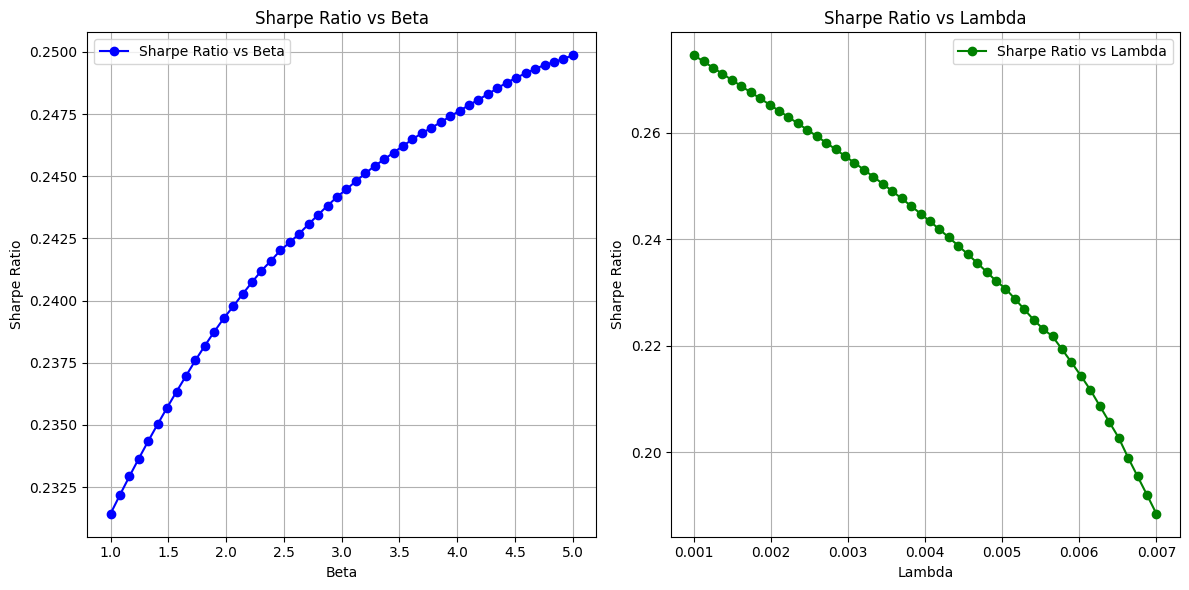

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N = 100  # 100 trades in a day as paper suggested
Delta_t = 1 / N  
alpha = 1.67e-4  
sigma = 0.02  # Daily volatility
gamma = 0.5  
phi = np.log(2) / 5  # Mean-reversion rate
beta = 2.0  
lambda_impact = 0.0035  
p = 0.5  

# Simulate the strategy
def simulate_strategy(N, Delta_t, alpha, lambda_impact, gamma, beta, sigma, p):

    alpha_hat = alpha * (1 - np.exp(-beta * Delta_t)) / (beta * Delta_t)
    lambda_hat = lambda_impact * (1 - np.exp(-beta * (p + 1) * p * Delta_t)) / (beta * (p + 1) * Delta_t)

    f = np.zeros(N)  
    Q = np.zeros(N)  
    J_prime = np.zeros(N)  
    PnL = np.zeros(N)  
    
    np.random.seed(4)
    for n in range(1, N):
        Z = np.random.randn()
        f[n] = f[n-1] * np.exp(-phi * Delta_t) + np.sqrt(1 - np.exp(-2 * phi * Delta_t)) * Z

    # Simulate strategy
    for n in range(1, N):
        # Optimal holdings (Q_n)
        Q[n] = alpha_hat * f[n-1] - lambda_hat * np.sign(J_prime[n-1] + Q[n-1]) * np.abs(J_prime[n-1] + Q[n-1])**p
        
        # Update exponential decay kernel (J_n)
        J_prime[n] = np.exp(-beta * Delta_t) * J_prime[n-1] - (1 - np.exp(-beta * Delta_t)) * Q[n]
        
        # Compute PnL components
        term1 = alpha_hat * Q[n] * f[n-1]
        term2 = lambda_hat * np.abs(J_prime[n] + Q[n])**(p+1)
        term3 = 0.5 * gamma * sigma**2 * Q[n]**2 * Delta_t
        PnL[n] = term1 - term2 - term3

    # Compute cumulative PnL and risk
    cumulative_pnl = np.sum(PnL)  # Total PnL
    risk = np.sqrt(np.sum(gamma * sigma**2 / 2 * Q**2 * Delta_t))  # Risk (Equation C.8)
    sharpe_ratio = cumulative_pnl / risk  # Sharpe Ratio (Equation C.13)
    
    return sharpe_ratio, cumulative_pnl, risk

# Sharpe Ratio vs Beta
beta_values = np.linspace(1, 5, 50)
sharpe_ratios_beta = []
for beta in beta_values:
    sharpe_ratio, _, _ = simulate_strategy(N, Delta_t, alpha, lambda_impact, gamma, beta, sigma, p)
    sharpe_ratios_beta.append(sharpe_ratio)

# Sharpe Ratio vs Lambda
lambda_values = np.linspace(0.001, 0.007, 50)
sharpe_ratios_lambda = []
for lambda_impact in lambda_values:
    sharpe_ratio, _, _ = simulate_strategy(N, Delta_t, alpha, lambda_impact, gamma, beta, sigma, p)
    sharpe_ratios_lambda.append(sharpe_ratio)


plt.figure(figsize=(12, 6))

# Sharpe Ratio vs Beta
plt.subplot(1, 2, 1)
plt.plot(beta_values, sharpe_ratios_beta, label="Sharpe Ratio vs Beta", color='blue', marker='o')
plt.xlabel("Beta")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio vs Beta")
plt.grid()
plt.legend()

# Sharpe Ratio vs Lambda
plt.subplot(1, 2, 2)
plt.plot(lambda_values, sharpe_ratios_lambda, label="Sharpe Ratio vs Lambda", color='green', marker='o')
plt.xlabel("Lambda")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio vs Lambda")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


# Question 3 (Due to time constraints, only use two models)

# Neural Network Architectures and Training Overview

## Neural Network Architectures

### 1. NetSimple
The holdings \( Q_n \) are directly output by the neural network:
$$
Q_n = \text{NN}_\theta(10^6 \cdot f_{n-1}, J_{n-1}^\prime)
$$

### 2. NetPower
The holdings \( Q_n \) are computed using a nonlinear transformation:
$$
Q_n = \text{NL}(\text{NN}_\theta(10^6 \cdot f_{n-1}, J_{n-1}^\prime)) - J_{n-1}^\prime
$$

The nonlinear function \( \text{NL}(x) \) is defined as:
$$
\text{NL}(x) = 
\begin{cases} 
   \text{sign}(x) |x|^{1/p}, & \text{if } |x| < B \\
   ax + \text{sign}(x)b, & \text{otherwise}
\end{cases}
$$

Where:
$$
a = \frac{1}{p} B^{1/p - 1}, \quad b = B^{1/p} - aB
$$

### 3. NetLinear
A simple linear neural network:
$$
Q_n = \text{L}_\theta(10^6 \cdot f_{n-1}, J_{n-1}^\prime)
$$

---

## Impact State Update
The adjusted impact state \( J_n^\prime \) evolves as:
$$
J_n^\prime = e^{-\beta \Delta t} J_{n-1}^\prime - (1 - e^{-\beta \Delta t}) Q_n
$$

---

## Objective Function
The goal is to maximize the expected cumulative reward:
$$
\max_\theta \mathbb{E} \left[ \sum_{n=1}^N \left( \hat{\alpha} Q_n f_{n-1} - \frac{\gamma \sigma^2}{2} Q_n^2 \Delta t - \hat{\beta} |J_n^\prime|^{p+1} \right) \right]
$$

---

## Training Procedure

### 1. Compute Holdings \( Q_n \):
- **For NetSimple and NetLinear:**
  $$
  Q_n = \text{NN}_\theta(10^6 \cdot f_{n-1}, J_{n-1}^\prime)
  $$
- **For NetPower:**
  $$
  Q_n = \text{NL}(\text{NN}_\theta(10^6 \cdot f_{n-1}, J_{n-1}^\prime)) - J_{n-1}^\prime
  $$

### 2. Update Adjusted Impact State \( J_n^\prime \):
$$
J_n^\prime = e^{-\beta \Delta t} J_{n-1}^\prime - (1 - e^{-\beta \Delta t}) Q_n
$$

### 3. Compute the Objective Function:
$$
\text{Objective} = \sum_{n=1}^N (\text{Term1}_n - \text{Term2}_n - \text{Term3}_n)
$$

### 4. Training Loss:
Since we aim to maximize the objective, the loss function to minimize is:
$$
\text{Loss} = -\frac{1}{\text{batch size}} \sum_{\text{batch}} \text{Objective}
$$

### 5. Optimization:
Update the neural network parameters \( \theta \) using gradient descent:
$$
\theta \leftarrow \theta - \eta \nabla_\theta \text{Loss}
$$

---

## Summary
This methodology employs neural networks to optimize trading strategies in a discrete setting by maximizing cumulative reward, with three architectures (NetSimple, NetPower, and NetLinear). The training loss represents the negative objective function, and the parameters \( \theta \) are updated using gradient descent.


In [ ]:
np.random.seed(4)
tf.random.set_seed(4)

# Time parameters
dt = 0.01       
N = 5120       
M = 256000       
num_epochs = 50  
batch_size = 1024 

# Market parameters
sigma = 0.02
phi = np.log(2) / 5
alpha = 1.67e-4
lambda_impact = 0.0035
beta = 2
gamma = 0.01
delta_t = dt

alpha_hat = alpha * (1 - np.exp(-beta * delta_t)) / (beta * delta_t)
lambda_hat = lambda_impact * (1 - np.exp(-beta * delta_t)) / (beta * delta_t)

initial_lr = 1e-4  # As per the paper for NetSimple
decay_factor = 0.25 # suggested by the paper to shrink lr
decay_epochs = [30, 35, 40, 45]

# Initialize covariance matrix 
cov_distribution = np.eye(3)

def generate_signal_and_states(batch_size, sequence_length, cov_distribution):
    phi_dt = np.exp(-phi * delta_t)
    sqrt_term = np.sqrt(1 - np.exp(-2 * phi * delta_t))
    f = np.zeros((batch_size, sequence_length))
    Q_prev = np.zeros(batch_size)
    J0_prev = np.zeros(batch_size)

    mean = np.zeros(3)
    initial_states = np.random.multivariate_normal(mean, cov_distribution, size=batch_size)
    f[:, 0] = initial_states[:, 0]
    Q_prev = initial_states[:, 1]
    J0_prev = initial_states[:, 2]

    for n in range(1, sequence_length):
        Z_n = np.random.randn(batch_size)
        f[:, n] = phi_dt * f[:, n - 1] + sqrt_term * Z_n

    return f, Q_prev, J0_prev

# NetSimple model definition
def create_netsimple_model():
    model = models.Sequential([
        layers.Input(shape=(2,)),
        layers.Dense(128, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(8, activation='relu'),
        layers.Dense(1)
    ])
    return model

# NetLinear model definition
def create_netlinear_model():
    model = models.Sequential([
        layers.Input(shape=(2,)),
        layers.Dense(1)  # Linear layer
    ])
    return model
    
# Nonlinear transformation NL(x) as per equation (C.20)
def NL(x, p, B=10):
    # Compute |x|^(1/p)
    with np.errstate(divide='ignore', invalid='ignore'):
        exponent = 1 / p if p != 0 else 1 
        x_abs = np.abs(x)
        x_transformed = np.sign(x) * x_abs ** exponent

    # Linear region for |x| >= B
    mask = x_abs >= B
    if np.any(mask):
        a = exponent * (B ** (exponent - 1))
        b = (B ** exponent) - a * B
        x_transformed[mask] = a * x[mask] + np.sign(x[mask]) * b

    return x_transformed


In [ ]:
def train_step(model, optimizer, f_batch, Q_prev, J0_prev, cov_distribution):
    batch_size = f_batch.shape[0]
    sequence_length = f_batch.shape[1]

    with tf.GradientTape() as tape:
        Q = []
        J0_list = []
        J_list = []

        # Scale f as per the paper
        f_scaled = f_batch * 1e6

        # Iterate over time steps
        for n in range(sequence_length):
            f_prev = f_scaled[:, n]
            inputs = tf.stack([f_prev, J0_prev], axis=1)
            Q_n = model(inputs)[:, 0]
            J0_n = tf.exp(-beta * delta_t) * J0_prev - (1 - tf.exp(-beta * delta_t)) * Q_n
            J_n = Q_n + J0_n

            Q.append(Q_n)
            J0_list.append(J0_n)
            J_list.append(J_n)
            J0_prev = J0_n
            
        Q = tf.stack(Q, axis=1)  
        J = tf.stack(J_list, axis=1) 

        # Compute objective function
        term1 = alpha_hat * Q[:, :-1] * f_scaled[:, :-1]
        term2 = -lambda_hat * tf.abs(J[:, :-1])
        term3 = -0.5 * gamma * sigma**2 * tf.square(Q[:, :-1]) * delta_t

        objective = tf.reduce_mean(tf.reduce_sum(term1 + term2 + term3, axis=1))
        loss = -objective

    grads = tape.gradient(loss, model.trainable_variables)
    grads = [tf.clip_by_value(g, -1., 1.) for g in grads]  #clipping
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Update covariance matrix for state initialization
    f_sample = f_batch[:, 0]
    Q_sample = Q[:, 0]
    J_sample = J[:, 0]
    sample_states = tf.stack([f_sample, Q_sample, J_sample], axis=1).numpy()
    cov_sample = np.cov(sample_states, rowvar=False)
    cov_distribution = 0.999 * cov_distribution + 0.001 * cov_sample

    return loss, cov_distribution

# Training loop function
def train_model(model, num_epochs, initial_lr, decay_epochs, decay_factor, is_linear=False):
    lr = initial_lr
    optimizer = optimizers.Adam(learning_rate=lr)
    global cov_distribution  # update the global covariance matrix

    for epoch in range(num_epochs):
        # Adjust learning rate
        if epoch in decay_epochs:
            lr *= decay_factor
            optimizer.learning_rate.assign(lr)
        f_batch, Q_prev, J0_prev = generate_signal_and_states(batch_size, N, cov_distribution)


        Q_prev = tf.convert_to_tensor(Q_prev, dtype=tf.float32)
        J0_prev = tf.convert_to_tensor(J0_prev, dtype=tf.float32)

        loss, cov_distribution = train_step(model, optimizer, f_batch, Q_prev, J0_prev, cov_distribution)

        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.numpy():.6f}")

    print("Training completed.")

def evaluate_model(model):
    batch_size_eval = 5000  
    sequence_length_eval = M
    f_eval, Q_prev, J0_prev = generate_signal_and_states(batch_size_eval, sequence_length_eval, cov_distribution) 
    f_scaled = f_eval * 1e6
    Q = np.zeros((batch_size_eval, sequence_length_eval))
    J = np.zeros((batch_size_eval, sequence_length_eval))
    PnL = np.zeros((batch_size_eval, sequence_length_eval))
    exp_beta_dt = np.exp(-beta * delta_t)
    one_minus_exp_beta_dt = 1 - exp_beta_dt
    verbose = 0

    for n in range(sequence_length_eval):
        f_prev = f_scaled[:, n]
        # Input 
        inputs = np.stack([f_prev, J0_prev], axis=1)
        Q_n = model.predict(inputs, batch_size=1024, verbose=verbose).flatten()
        J0_n = exp_beta_dt * J0_prev - one_minus_exp_beta_dt * Q_n
        J_n = Q_n + J0_n
        Q[:, n] = Q_n
        J[:, n] = J_n
        epsilon_n = np.random.randn(batch_size_eval)
        dS_n = alpha * f_prev * delta_t + sigma * np.sqrt(delta_t) * epsilon_n

        if n == 0:
            Q_prev_shifted = Q_prev
        else:
            Q_prev_shifted = Q[:, n - 1]
        PnL[:, n] = Q_prev_shifted * dS_n - lambda_impact * np.abs(Q_n - Q_prev_shifted)
        J0_prev = J0_n

    # Compute total PnL and risk
    total_PnL = np.sum(PnL, axis=1)
    risk = sigma * np.sqrt(np.mean(Q ** 2, axis=1))
    sharpe_ratio = np.mean(total_PnL / risk)
    avg_risk = np.mean(risk)

    return sharpe_ratio, avg_risk

In [ ]:
# Training and evaluating NetSimple
print("Training NetSimple model...")
netsimple_model = create_netsimple_model()
train_model(netsimple_model, num_epochs, initial_lr, decay_epochs, decay_factor)
print("Evaluating NetSimple model...")
sharpe_ratio_netsimple, avg_risk_netsimple = evaluate_model(netsimple_model)
print(f"NetSimple Sharpe Ratio: {sharpe_ratio_netsimple:.3f}, Risk: {avg_risk_netsimple:.0f}")

initial_lr_linear = 1e-2  # As per the paper for NetLinear
decay_epochs_linear = [30, 35, 40, 45]
decay_factor_linear = 0.25

# covmatrix initialization
cov_distribution = np.eye(3)

# Training and evaluating 
print("\nTraining NetLinear model...")
netlinear_model = create_netlinear_model()
train_model(netlinear_model, num_epochs, initial_lr_linear, decay_epochs_linear, decay_factor_linear, is_linear=True)
print("Evaluating NetLinear model...")
sharpe_ratio_netlinear, avg_risk_netlinear = evaluate_model(netlinear_model)
print(f"NetLinear Sharpe Ratio: {sharpe_ratio_netlinear:.3f}, Risk: {avg_risk_netlinear:.0f}")
print("\nPerformance Comparison:")
print(f"NetSimple - Sharpe Ratio: {sharpe_ratio_netsimple:.3f}, Risk: {avg_risk_netsimple:.0f}")
print(f"NetLinear - Sharpe Ratio: {sharpe_ratio_netlinear:.3f}, Risk: {avg_risk_netlinear:.0f}")


Training NetSimple model...
Epoch 5/50, Loss: 0.367040
Epoch 10/50, Loss: 0.357522
Epoch 15/50, Loss: 0.353183
Epoch 20/50, Loss: 0.347533
Epoch 25/50, Loss: 0.352935
Epoch 30/50, Loss: 0.338224
Epoch 35/50, Loss: 0.338067
Epoch 40/50, Loss: 0.344190
Epoch 45/50, Loss: 0.335338
Epoch 50/50, Loss: 0.341328
Training completed.
Evaluating NetSimple model...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 